In [8]:
import pybamm
from tqdm import tqdm
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import scienceplots
from bayes_opt import BayesianOptimization
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.interpolate import Akima1DInterpolator
plt.style.use(['science','nature','no-latex'])

In [3]:
experiment = pybamm.Experiment(
    [
        (
            "Rest for 30 minutes",
            "Charge at C/4 until 4.1 V",
        ),
    ]
)   
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, experiment=experiment, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution = sim.solve(initial_soc=0.0)

In [4]:
t = solution["Time [s]"].data
V = solution["Voltage [V]"].data
A = solution["Current [A]"].data
soc = solution["Discharge capacity [A.h]"].data/solution['Total lithium capacity [A.h]'].data
Q = cumtrapz(A, t, initial=0)
dQdV = np.gradient(Q,V,edge_order=2)

# Plot the standart CCCV

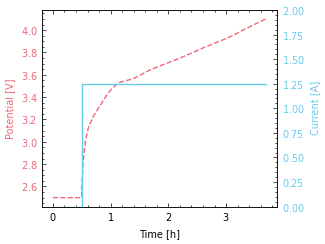

In [5]:
fig, ax1 = plt.subplots()

color = '#EE6677'
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Potential [V]', color=color)
ax1.plot(t/3600,V,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#66CCEE'
ax2.set_ylabel('Current [A]', color=color)  # we already handled the x-label with ax1
ax2.plot(t/3600,-A, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.ylim(0.0,2)
plt.savefig("/Users/helgesorenstein/Documents/python/charge_CC_okane2022.svg")
plt.show()

# Check dQdV for CCCV

(0.0, 4.0)

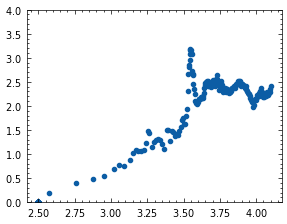

In [6]:
plt.scatter(V,np.sqrt(-dQdV/3600))
plt.ylim(0,4)

# Run the same experiment but set as voltage!

In [7]:
#need to be careful because the simulation does really not like to start with resting
ix = np.where(A!=0)[0]
set_voltage = np.array([t[ix]-t[ix[0]],V[ix]])
#set_voltage = np.array([t,V])

Text(0, 0.5, 'Voltage [V]')

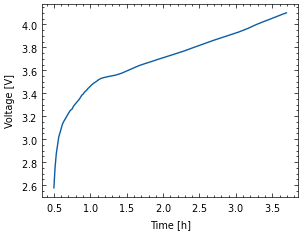

In [8]:
#plot the voltage profile
plt.plot(t[ix]/3600,V[ix])
plt.xlabel('Time [h]')
plt.ylabel('Voltage [V]')

In [9]:
#now we run the same experiment but we set the voltage instead of measuring it!
experiment_sv = pybamm.Experiment(
    [
        (
            "Rest for 30 minutes",
            pybamm.step.voltage(set_voltage.T)
        ),
    ]
)   
model_sv = pybamm.lithium_ion.DFN()
sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution_sv = sim_sv.solve(initial_soc=0.0)

In [10]:
t_sv = solution_sv["Time [s]"].data
V_sv = solution_sv["Voltage [V]"].data
A_sv = solution_sv["Current [A]"].data
Q_sv = cumtrapz(A_sv, t_sv, initial=0)
dQdV_sv = np.gradient(Q_sv,V_sv,edge_order=2)

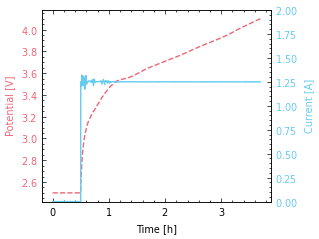

In [11]:
fig, ax1 = plt.subplots()

color = '#EE6677'
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Potential [V]', color=color)
ax1.plot(t_sv/3600,V_sv,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#66CCEE'
ax2.set_ylabel('Current [A]', color=color)  # we already handled the x-label with ax1
ax2.plot(t_sv/3600,-A_sv, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(0.0,2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("/Users/helgesorenstein/Documents/python/nonlin_OKane2022.svg")
plt.show()

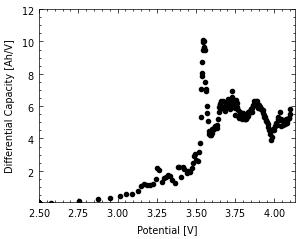

In [12]:
plt.scatter(V,-dQdV/3600,color='black')
plt.ylim(0.1,12)
plt.xlim(2.5,4.13)
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dQdV.svg")

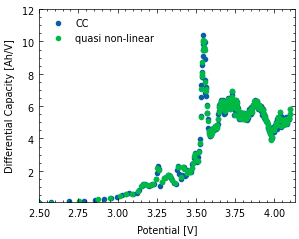

In [13]:
plt.scatter(V_sv,-dQdV_sv/3600,label="CC")
plt.scatter(V,-dQdV/3600,label="quasi non-linear")
plt.legend()
plt.ylim(0.1,12)
plt.xlim(2.5,4.13)
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dQdV_both.svg")

In [14]:
Vi = interp1d(t,V)(t_sv)
Ai = interp1d(t,A)(t_sv)
Qi = cumtrapz(Ai, t_sv, initial=0)
dQdVi = np.gradient(Qi,Vi,edge_order=2)

Check the error

In [15]:
print(np.percentile(-dQdVi/3600+dQdV_sv/3600,10))
print(np.percentile(-dQdVi/3600+dQdV_sv/3600,90))

-0.004758937722427525
0.003343060489666705


In [16]:
Vmod = copy(V)

# Linear sweep voltammetry

In [17]:
ergs = []
for amp in tqdm(np.linspace(10,0.1,50)):
    t = np.linspace(0,3600*amp,360)
    V = np.linspace(2.5,4.1,360)
    
    set_voltage = np.array([t,V])
    experiment_sv = pybamm.Experiment(
            [
                (
                    pybamm.step.voltage(set_voltage.T)
                ),
            ]
        )   
    model_sv = pybamm.lithium_ion.DFN()
    sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
    solution_sv = sim_sv.solve(initial_soc=0)
    t_sv = solution_sv["Time [s]"].data
    V_sv = solution_sv["Voltage [V]"].data
    A_sv = solution_sv["Current [A]"].data
    Qc = cumtrapz(A_sv, t_sv, initial=0)
    dQdV = np.gradient(Qc,V_sv,edge_order=2)
    ergs.append(dict(t_sv=t_sv,V_sv=V_sv,A_sv=A_sv,V=V,dQdV=dQdV))

100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


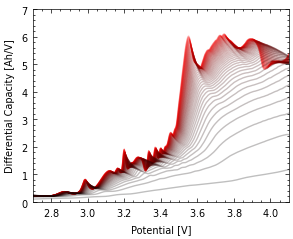

In [18]:
c = np.array([np.linspace(10,0.1,50)/10,np.zeros(50),np.zeros(50)])
for i,e in enumerate(ergs):
    plt.plot(e["V_sv"][10:],-e["dQdV"][10:]/3600,c=c.T[i],alpha=0.25)
plt.xlim(2.7,4.1)
plt.ylim(0,7)
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/lin_dQdV_okane2022.svg")

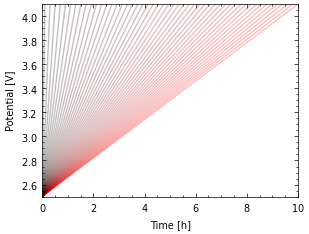

In [19]:
c = np.array([np.linspace(10,0.1,50)/10,np.zeros(50),np.zeros(50)])
for i,e in enumerate(ergs):
    plt.plot(e["t_sv"]/3600,e["V_sv"],c=c.T[i],alpha=0.25)
plt.ylim(2.5,4.1)
plt.xlim(0,10)
plt.xlabel('Time [h]')
plt.ylabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/lin_volt.svg")

In [20]:
ergs = []
for amp in tqdm(np.linspace(10,0.1,50)):
    t = np.linspace(0,3600*amp,360)
    V = np.linspace(4.1,2.5,360)
    
    set_voltage = np.array([t,V])
    experiment_sv = pybamm.Experiment(
            [
                (
                    pybamm.step.voltage(set_voltage.T)
                ),
            ]
        )   
    model_sv = pybamm.lithium_ion.DFN()
    sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
    solution_sv = sim_sv.solve(initial_soc=1)
    t_sv = solution_sv["Time [s]"].data
    V_sv = solution_sv["Voltage [V]"].data
    A_sv = solution_sv["Current [A]"].data
    Qc = cumtrapz(A_sv, t_sv, initial=0)
    dQdV = np.gradient(Qc,V_sv,edge_order=2)
    ergs.append(dict(t_sv=t_sv,V_sv=V_sv,A_sv=A_sv,V=V,dQdV=dQdV))

 98%|█████████▊| 49/50 [00:50<00:00,  1.08it/s]At t = 323.834 and h = 2.79954e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 29.8279 and h = 4.72146e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 27.496 and h = 4.17175e-07, the corrector convergence failed repeatedly or with |h| = hmin.
100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


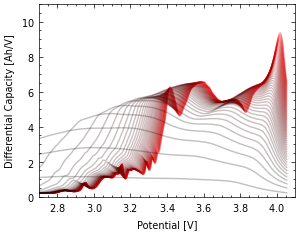

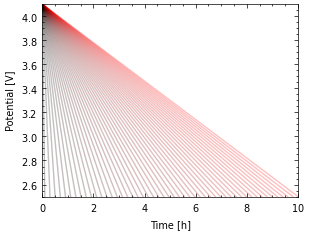

In [21]:

plt.figure()    
c = np.array([np.linspace(10,0.1,50)/10,np.zeros(50),np.zeros(50)])
for i,e in enumerate(ergs):
    plt.plot(e["V_sv"][10:],-e["dQdV"][10:]/3600,c=c.T[i],alpha=0.25)
plt.xlim(2.7,4.1)
plt.ylim(0,11)
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/lin_dQdV_dis_okane2022.svg")

plt.figure()
c = np.array([np.linspace(10,0.1,50)/10,np.zeros(50),np.zeros(50)])
for i,e in enumerate(ergs):
    plt.plot(e["t_sv"]/3600,e["V_sv"],c=c.T[i],alpha=0.25)
plt.ylim(2.5,4.1)
plt.xlim(0,10)
plt.xlabel('Time [h]')
plt.ylabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/lin_volt_dis_okane2022.svg")

In [3]:
#don't run this, it takes forever
_ = '''
ergs = []
for freq in tqdm([360*2,360,360/2]):
    for speed in np.linspace(10,0.1,10):
        for amp in np.linspace(0,(4.199-2.7)/100,10):
            t = np.linspace(0,3600*speed,1000)
            V = np.linspace(4.199,2.7,1000)+amp*np.cos(t/freq*np.pi)
            
            set_voltage = np.array([t,V])
            experiment_sv = pybamm.Experiment(
                    [
                        (
                            pybamm.step.voltage(set_voltage.T),
                        ),
                    ]
                )   
            model_sv = pybamm.lithium_ion.DFN()
            sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'))
            solution_sv = sim_sv.solve(initial_soc=1)
            t_sv = solution_sv["Time [s]"].data
            V_sv = solution_sv["Voltage [V]"].data
            A_sv = solution_sv["Current [A]"].data
            Qc = cumtrapz(A_sv, t_sv, initial=0)
            dQdV = np.gradient(Qc,V_sv,edge_order=2)
            ergs.append(dict(t_sv=t_sv,V_sv=V_sv,A_sv=A_sv,V=V,dQdV=dQdV,pars=(freq,speed,amp)))
'''

In [4]:
import pickle
#pickle.dump(ergs,open("/Users/helgesorenstein/Documents/python/discharges_phase.pck","wb"))

In [5]:
#ergs = pickle.load(open("/Users/helgesorenstein/Documents/python/discharges_phase.pck","rb"))

In [6]:
_ = '''
vv,qq = [],[]
for e in ergs:
    vv.extend(e["V_sv"])
    qq.extend(-e["dQdV"]/3600)
_ = plt.hist2d(vv,qq,100,range=((3.2,4.1),(0,10)),norm=mpl.colors.LogNorm())
'''

# Test sin superposition

In [10]:
ergs_shift = []
freq = 360
for amp in tqdm(np.linspace(0,1.5*0.00666222222222222,10)):
    for phase in np.linspace(0,2,10):
        t = np.linspace(0,3600*4,1000)
        V = np.linspace(2.5,4.2,1000)+amp*np.cos(t/freq*np.pi+np.pi*phase)
        
        set_voltage = np.array([t,V])
        experiment_sv = pybamm.Experiment(
                [
                    (
                        pybamm.step.voltage(set_voltage.T),
                    ),
                ]
            )   
        model_sv = pybamm.lithium_ion.DFN()
        sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
        solution_sv = sim_sv.solve(initial_soc=0.0)
        t_sv = solution_sv["Time [s]"].data
        V_sv = solution_sv["Voltage [V]"].data
        A_sv = solution_sv["Current [A]"].data
        Qc = cumtrapz(A_sv, t_sv, initial=0)
        dQdV = np.gradient(Qc,V_sv,edge_order=2)
        ergs_shift.append(dict(t_sv=t_sv,V_sv=V_sv,A_sv=A_sv,V=V,dQdV=dQdV,pars=(freq,0.0,amp,phase)))

100%|██████████| 10/10 [02:34<00:00, 15.49s/it]


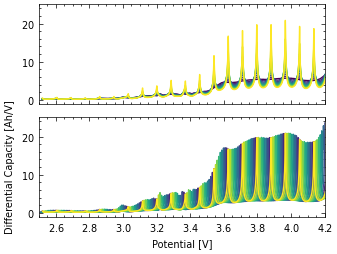

In [11]:
import matplotlib.colors as mcolors

colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(2,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1.5*0.00666222222222222*1000)
color = colormap(norm(np.linspace(0,1.5*0.00666222222222222*1000,10)))
for i in range(10):
    ax[0].plot(ergs_shift[10*i]["V_sv"][10:,],-ergs_shift[10*i]["dQdV"][10:,]/3600,c=color[i])
'''
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0])
cbar.set_label('Amplitude [mV]')
'''
i=9
norm2 = mcolors.Normalize(vmin=0, vmax=2)
color2 = colormap(norm2(np.linspace(0,2,10)))
for j in range(10):
    ax[1].plot(ergs_shift[10*i+j]["V_sv"][10:,],-ergs_shift[10*i+j]["dQdV"][10:,]/3600,c=color2[j])
plt.tight_layout()
plt.xlim(2.5,4.2)
plt.ylim(-1,25)
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/amp_phase_okane2022_charge.svg")

In [12]:
gr = np.gradient(ergs_shift[10*i]["V_sv"][10:,],ergs_shift[10*i]["t_sv"][10:,])

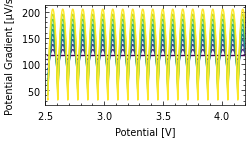

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

fig = plt.figure()
adjustFigAspect(fig,aspect=2)
ax = fig.add_subplot(111)

#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1.5*0.00666222222222222*1000)
color = colormap(norm(np.linspace(0,1.5*0.00666222222222222*1000,10)))
for i in range(10):
    gr = np.gradient(ergs_shift[10*i]["V_sv"][10:,],ergs_shift[10*i]["t_sv"][10:,])
    ax.plot(ergs_shift[10*i]["V_sv"][10:,],gr*1000000,c=color[i])
#plt.tight_layout()
plt.xlim(2.5,4.2)
#plt.ylim(-1,25)
plt.xlabel('Potential [V]')
plt.ylabel('Potential Gradient [µV/s]')
plt.savefig("/Users/helgesorenstein/Documents/python/amp_phase_okane2022_charge_grad.svg")

In [17]:
hv,hdqdv = [],[]
for m in range(len(ergs_shift)):
    hv.extend(ergs_shift[m]["V_sv"][10:,])
    hdqdv.extend(-ergs_shift[m]["dQdV"][10:,]/3600)

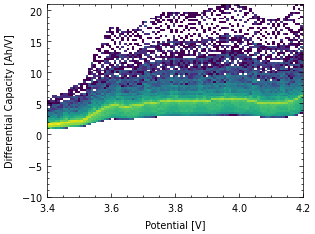

In [18]:
_ = plt.hist2d(hv,hdqdv,(100,100),range=((3.4,4.2),(-10,21)),norm=mpl.colors.LogNorm())
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/hist2d.svg")

# Adding a bump to the linear protocol

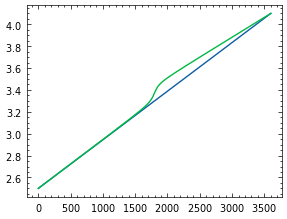

In [20]:
n=1#hours
n2=0.5#breah after hour
vdiff = 0.3#vdiff
x = np.linspace(0,3600*n,3600)
me = max(np.arctan((x-3600*n2)/50)/np.pi)
mi = np.arctan((x[0]-3600*n2)/50)/np.pi

atan = np.arctan((x-3600*n2)/50)/np.pi-mi

V1 = np.linspace(2.5,4.1,3600)
V2 = np.linspace(2.5,4.1,3600)+vdiff*atan-vdiff*atan*x/3600

plt.plot(x,V1)
plt.plot(x,V2)


In [22]:
ergs_shift2 = []
for br in tqdm(np.linspace(0,10,10)):
    
    n=10#hours
    n2=br#breah after hour
    vdiff = 0.1#vdiff
    x = np.linspace(0,3600*n,1000)
    me = max(np.arctan((x-3600*n2)/50)/np.pi)
    mi = np.arctan((x[0]-3600*n2)/50)/np.pi
    
    atan = np.arctan((x-3600*n2)/50)/np.pi-mi
    
    V = np.linspace(2.5,4.1,1000)+vdiff*atan-vdiff*atan*x/3600/n
    
    set_voltage = np.array([x,V])
    experiment_sv = pybamm.Experiment(
            [
                (
                    pybamm.step.voltage(set_voltage.T)
                ),
            ]
        )   
    model_sv = pybamm.lithium_ion.DFN()
    sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
    solution_sv = sim_sv.solve(initial_soc=0)
    t_sv = solution_sv["Time [s]"].data
    V_sv = solution_sv["Voltage [V]"].data
    A_sv = solution_sv["Current [A]"].data
    Qc = cumtrapz(A_sv, t_sv, initial=0)
    dQdV = np.gradient(Qc,V_sv,edge_order=2)
    ergs_shift2.append(dict(t_sv=t_sv,V_sv=V_sv,A_sv=A_sv,V=V,dQdV=dQdV,pars=(freq,0.0,amp,phase)))

100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


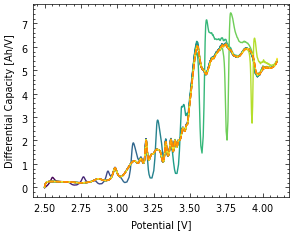

In [23]:
V = np.linspace(2.5,4.1,1000)
x = np.linspace(0,3600*n,1000)

set_voltage = np.array([x,V])
experiment_sv = pybamm.Experiment(
        [
            (
                pybamm.step.voltage(set_voltage.T)
            ),
        ]
    )   
model_sv = pybamm.lithium_ion.DFN()
sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution_sv = sim_sv.solve(initial_soc=0)
t_sv = solution_sv["Time [s]"].data
V_sv = solution_sv["Voltage [V]"].data
A_sv = solution_sv["Current [A]"].data
Qc = cumtrapz(A_sv, t_sv, initial=0)
dQdV = np.gradient(Qc,V_sv,edge_order=2)

colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=10)
color = colormap(norm(np.linspace(0,10,10)))
for i in range(10):
    ax.plot(ergs_shift2[i]["V_sv"],-ergs_shift2[i]["dQdV"]/3600,c=color[i])
ax.plot(V_sv,-dQdV/3600,'--',c='red')

#and the slow plot
V = np.linspace(2.5,4.1,1000)
x = np.linspace(0,3600*10,1000)

set_voltage = np.array([x,V])
experiment_sv = pybamm.Experiment(
        [
            (
                pybamm.step.voltage(set_voltage.T)
            ),
        ]
    )   
model_sv = pybamm.lithium_ion.DFN()
sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution_sv = sim_sv.solve(initial_soc=0)
t_sv = solution_sv["Time [s]"].data
V_sv = solution_sv["Voltage [V]"].data
A_sv = solution_sv["Current [A]"].data
Qc = cumtrapz(A_sv, t_sv, initial=0)
dQdV = np.gradient(Qc,V_sv,edge_order=2)
ax.plot(V_sv,-dQdV/3600,'--',c='orange')
plt.xlabel('Potential [V]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/shifting_step_lower.svg")

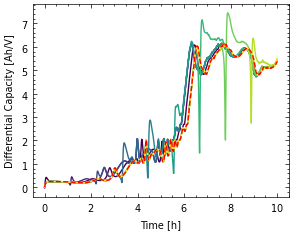

In [24]:
fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=10)
color = colormap(norm(np.linspace(0,10,10)))
for i in range(10):
    ax.plot(ergs_shift2[i]["t_sv"]/3600,-ergs_shift2[i]["dQdV"]/3600,c=color[i])
    #ax.scatter(ergs_shift2[i]["t_sv"][-1]/3600,-ergs_shift2[i]["dQdV"][-1]/3600,c='black')
ax.plot(t_sv/3600,-dQdV/3600,'--',c='red')
plt.xlabel('Time [h]')
plt.ylabel('Differential Capacity [Ah/V]')
plt.savefig("/Users/helgesorenstein/Documents/python/shifting_step_over_potential.svg")

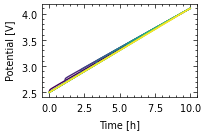

In [25]:
fig,ax = plt.subplots(1,1,sharex=True, sharey=True,figsize=(2,1.2))
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=10)
color = colormap(norm(np.linspace(0,10,10)))
for i in range(10):
    ax.plot(ergs_shift2[i]["t_sv"]/3600,ergs_shift2[i]["V_sv"],c=color[i])
plt.ylabel('Potential [V]')
plt.xlabel('Time [h]')
plt.savefig("/Users/helgesorenstein/Documents/python/shift_pot_time_smaller.svg")

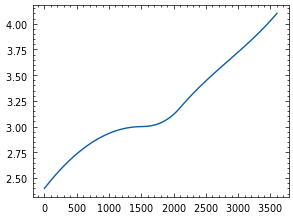

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
x = np.linspace(0,3600,3600)
Vs,Ve = 2.4,4.1
Vstop = 3.0
tstop = 600
tstopstart = 1500
tot = 3600
slopes_begin = (Ve-Vs)/(tot-tstopstart)
slopes_end = (Ve-Vstop)/(tot-tstop-tstopstart)
slope = (Ve-Vstop)/(tot)

times = [0,tstopstart,tstopstart+tstop,tot]
values = [Vs,Vstop,Vstop+slope*tstop,Ve]
slopes = [slopes_begin,0,slopes_end,slopes_end]
spline = CubicHermiteSpline(times, values, slopes)

plt.plot(x,spline(x))

In [28]:
ergs_shift3 = []
for br in tqdm(np.linspace(2.45,4.05,10)):
    
    x = np.linspace(0,3600,3600)
    Vs,Ve = 2.4,4.1
    Vstop = br
    tstop = 600
    tstopstart = 1500
    tot = 3600
    slopes_begin = (Ve-Vs)/(tot-tstopstart)
    slopes_end = (Ve-Vstop)/(tot-tstop-tstopstart)
    slope = (Ve-Vstop)/(tot)

    times = [0,tstopstart,tstopstart+tstop,tot]
    values = [Vs,Vstop,Vstop+slope*tstop,Ve]
    slopes = [slopes_begin,0,slopes_end,slopes_end]
    spline = CubicHermiteSpline(times, values, slopes)

    V = spline(x)
    set_voltage = np.array([x,V])
    experiment_sv = pybamm.Experiment(
            [
                (
                    pybamm.step.voltage(set_voltage.T)
                ),
            ]
        )   
    model_sv = pybamm.lithium_ion.DFN()
    sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
    solution_sv = sim_sv.solve(initial_soc=0)
    t_sv = solution_sv["Time [s]"].data
    V_sv = solution_sv["Voltage [V]"].data
    A_sv = solution_sv["Current [A]"].data
    Qc = cumtrapz(A_sv, t_sv, initial=0)
    dQdV = np.gradient(Qc,V_sv,edge_order=2)
    ergs_shift3.append(dict(t_sv=t_sv,V_sv=V_sv,A_sv=A_sv,V=V,dQdV=dQdV,pars=(freq,0.0,amp,phase)))

100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


(0.0, 10.0)

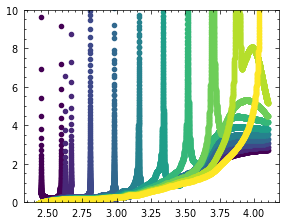

In [29]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1.5*0.00666222222222222*1000)
color = colormap(norm(np.linspace(0,1.5*0.00666222222222222*1000,10)))
for i in range(10):
    ax.scatter(ergs_shift3[i]["V_sv"][10:,],-ergs_shift3[i]["dQdV"][10:,]/3600,c=color[i])
plt.ylim(0,10)

In [30]:
ergs = []
for n in [10,15,20]:
    for amp in tqdm(np.linspace(0,0.045,10)):
        t = np.linspace(0,3600,3601)
        V = np.linspace(4.199,2.7,3601)-amp*np.sin(n*t/3600*np.pi)
        
        set_voltage = np.array([t,V])
        experiment_sv = pybamm.Experiment(
                [
                    (
                        pybamm.step.voltage(set_voltage.T)
                    ),
                ]
            )   
        model_sv = pybamm.lithium_ion.DFN()
        sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'))
        solution_sv = sim_sv.solve(initial_soc=1)
        t_sv = solution_sv["Time [s]"].data
        V_sv = solution_sv["Voltage [V]"].data
        A_sv = solution_sv["Current [A]"].data
        Qc = cumtrapz(A_sv, t_sv, initial=0)
        dQdV = np.gradient(Qc,V_sv,edge_order=2)
        ergs.append(dict(t=t_sv,V=V_sv,A=A_sv,Vintend=V,dQdV=dQdV,n=n,amp=amp))

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


In [391]:
x,y = [],[]
for e in ergs:
    x.extend(e['V'])
    y.extend(e['dQdV'])

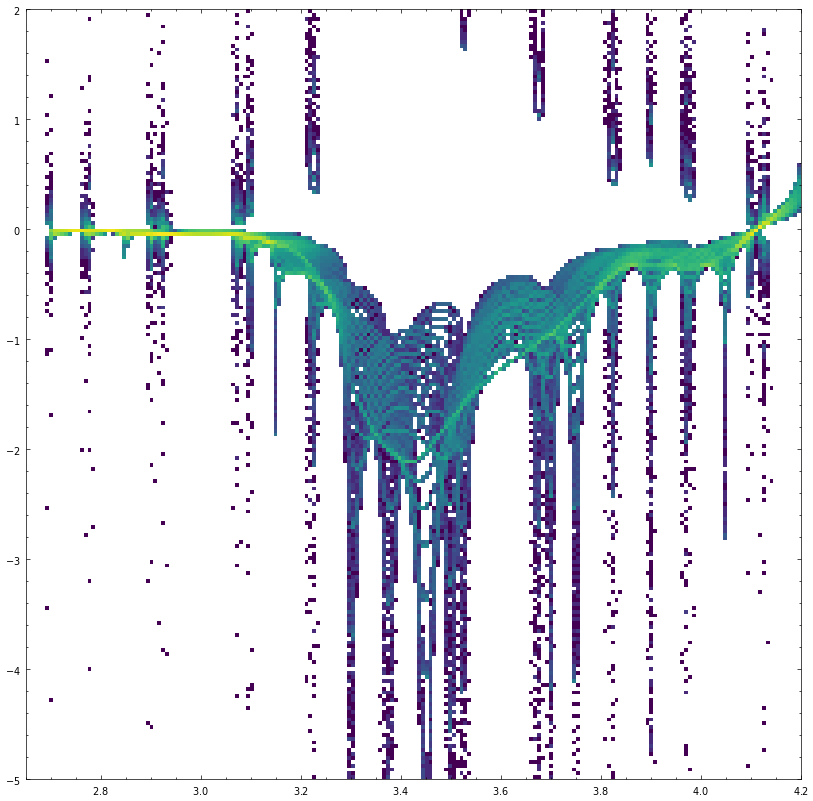

In [392]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(x,np.array(y)/3600,200,range=((2.65,4.2),(-5,2)),norm=mpl.colors.LogNorm())

In [395]:
x,y,z = [],[],[]
for e in ergs:
    if len(np.where(e['dQdV']>0)[0])<226:
        x.extend(e['V'])
        y.extend(e['dQdV'])
        z.extend(np.gradient(e['V'],e['t']))

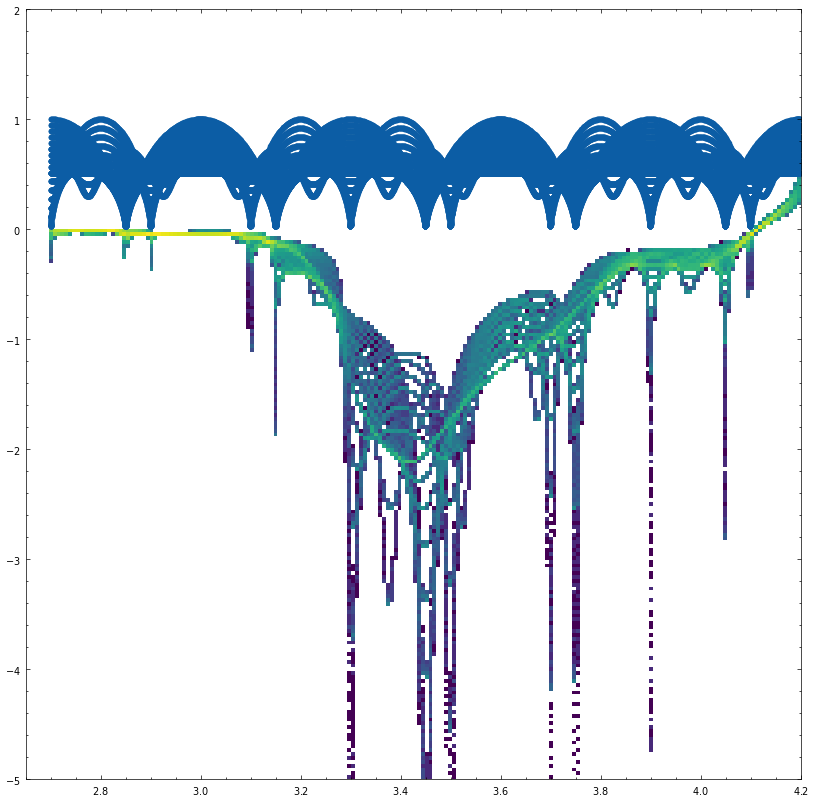

In [401]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(x,np.array(y)/3600,200,range=((2.65,4.2),(-5,2)),norm=mpl.colors.LogNorm())
plt.scatter(x,np.abs(z)/np.abs(z).max())

In [392]:
n = 3000
ttest = np.linspace(0,3600*4,n)
ampM = 0.00999
amps = [1/10*ampM,3/6*ampM,1/2*ampM]
freqs = [360,360*2,360/2]
phases = [0,1,1.5]
Vbase = np.linspace(4.199,2.7,n)
#first a function to generate Voltage signals
def vsig(t,amps,freqs,phases,Vbase=Vbase):
    for a,f,p in zip(amps,freqs,phases):
        Vbase += a*np.sin(t/f*np.pi+np.pi*p)
    return Vbase

y = vsig(ttest,amps,freqs,phases)

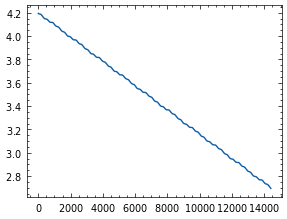

In [395]:
plt.plot(ttest,y)

In [418]:
set_voltage = np.array([ttest,y])
experiment_sv = pybamm.Experiment(
        [
            (
                pybamm.step.voltage(set_voltage.T),
            ),
        ]
    )   
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'))
solution = sim_sv.solve(initial_soc=1)
tsim = solution_sv["Time [s]"].data
Vsim = solution_sv["Voltage [V]"].data
Asim = solution_sv["Current [A]"].data
Qsim = cumtrapz(Asim, tsim, initial=0)
dQdVsim = np.gradient(Qsim,Vsim,edge_order=2)

# Potentiodynamic non-linear Charging

need the base CCCV to build off from

In [31]:
experiment = pybamm.Experiment(
    [
        (
            "Rest for 30 minutes",
            "Charge at 1C until 4.1 V",
            #"Hold at 4.1V until C/10"
        ),
    ]
)   
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, experiment=experiment, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution = sim.solve(initial_soc=0.0)

In [32]:
t = solution["Time [s]"].data
V = solution["Voltage [V]"].data
A = solution["Current [A]"].data
soc = solution["Discharge capacity [A.h]"].data/solution['Total lithium capacity [A.h]'].data
Q = cumtrapz(A, t, initial=0)
dQdV = np.gradient(Q,V,edge_order=2)
dVdQ = np.gradient(V,Q,edge_order=2)

same as above

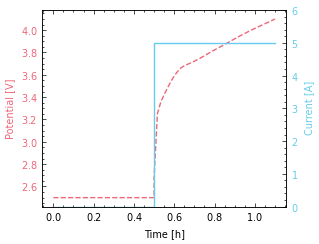

In [33]:
fig, ax1 = plt.subplots()

color = '#EE6677'
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Potential [V]', color=color)
ax1.plot(t/3600,V,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#66CCEE'
ax2.set_ylabel('Current [A]', color=color)  # we already handled the x-label with ax1
ax2.plot(t/3600,-A, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.ylim(0.0,6)
#plt.savefig("/Users/helgesorenstein/Documents/python/charge_CC_okane2022.svg")
plt.show()

In [34]:
experiment = pybamm.Experiment(
    [
        (
            "Rest for 30 minutes",
            "Charge at 1C until 4.1 V",
            #"Hold at 4.1V until C/10"
        ),
    ]
)   
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, experiment=experiment, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution = sim.solve(initial_soc=0.0)

t = solution["Time [s]"].data
V = solution["Voltage [V]"].data
A = solution["Current [A]"].data
soc = solution["Discharge capacity [A.h]"].data/solution['Total lithium capacity [A.h]'].data
Q = cumtrapz(A, t, initial=0)
dQdV = np.gradient(Q,V,edge_order=2)
dVdQ = np.gradient(V,Q,edge_order=2)

ix = np.where(A!=0)[0]
set_voltage_old = np.array([t[ix]-t[ix[0]],V[ix]])

generate a bump on the voltage profile - this is essentially charging it slower then faster and then same

In [50]:
V0 = 0.1
t0 = 1800
brt = 36

ti = np.linspace(set_voltage_old[0,0],set_voltage_old[0,-1],1000)
Vi = interp1d(set_voltage_old[0,:],set_voltage_old[1,:],kind='quadratic')(ti)

Vm,VM = min(Vi),max(Vi)
atan = V0*np.arctan((ti-t0)/brt)/np.pi
#this took too long to be correct ...
Vi += atan
Vi = (Vi-min(Vi))
Vi /= max(Vi)
Vi *= (VM-Vm)
Vi += Vm

#plt.plot(ti,Vi)
#plt.plot(set_voltage_old[0,:],set_voltage_old[1,:])

set_voltage = np.array([ti,Vi])

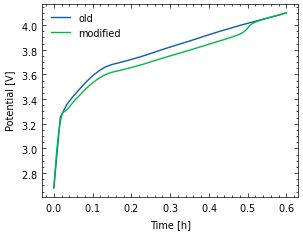

In [51]:
plt.plot(set_voltage_old[0,:]/3600,set_voltage_old[1,:],label="old")
plt.plot(ti/3600,Vi,label="modified")
plt.xlabel('Time [h]')
plt.ylabel('Potential [V]')
plt.legend()

In [52]:
experiment_sv = pybamm.Experiment(
    [
        (
            #"Rest for 30 minutes",
            pybamm.step.voltage(set_voltage.T)
        ),
    ]
)   
model_sv = pybamm.lithium_ion.DFN()
sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution_sv = sim_sv.solve(initial_soc=0.0)

In [53]:
t_sv = solution_sv["Time [s]"].data
V_sv = solution_sv["Voltage [V]"].data
A_sv = solution_sv["Current [A]"].data
Q_sv = cumtrapz(A_sv, t_sv, initial=0)
dQdV_sv = np.gradient(Q_sv,V_sv,edge_order=2)

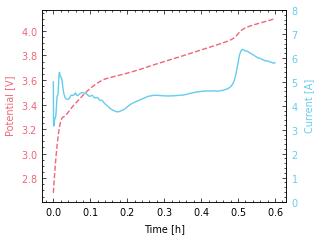

In [54]:

fig, ax1 = plt.subplots()

color = '#EE6677'
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Potential [V]', color=color)
ax1.plot(t_sv/3600,V_sv,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#66CCEE'
ax2.set_ylabel('Current [A]', color=color)  # we already handled the x-label with ax1
ax2.plot(t_sv/3600,-A_sv, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(0.0,8)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("/Users/helgesorenstein/Documents/python/nonlin_OKane2022.svg")
plt.show()

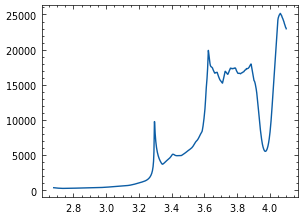

In [57]:
plt.plot(V_sv,-dQdV_sv)
#plt.plot(V,-dQdV)

In [58]:
ergs = []
for V0 in [0.1]:
    for t0 in tqdm(np.linspace(360,3600*0.6,10)):
        for brt in [36]:
            ti = np.linspace(set_voltage_old[0,0],set_voltage_old[0,-1],1000)
            Vi = interp1d(set_voltage_old[0,:],set_voltage_old[1,:])(ti)
            
            Vm,VM = min(Vi),max(Vi)
            atan = V0*np.arctan((ti-t0)/brt)/np.pi
            #schwere geburt ...
            Vi += atan
            Vi = (Vi-min(Vi))
            Vi /= max(Vi)
            Vi *= (VM-Vm)
            Vi += Vm
            
            #plt.plot(ti,Vi)
            #plt.plot(set_voltage_old[0,:],set_voltage_old[1,:])
            
            set_voltage = np.array([ti,Vi])
            
            experiment_sv = pybamm.Experiment(
                [
                    (
                        #"Rest for 30 minutes",
                        pybamm.step.voltage(set_voltage.T),
                    ),
                ]
            )   
            model_sv = pybamm.lithium_ion.DFN()
            sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
            solution_sv = sim_sv.solve(initial_soc=0.0)

        t_sv = solution_sv["Time [s]"].data
        V_sv = solution_sv["Voltage [V]"].data
        A_sv = solution_sv["Current [A]"].data
        Qc = cumtrapz(A_sv, t_sv, initial=0)
        dQdV = np.gradient(Qc,V_sv,edge_order=2)
        ergs.append(dict(t=t_sv,V=V_sv,A=A_sv,Vintend=V,dQdV=dQdV,n=n,amp=amp))

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


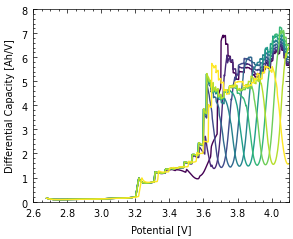

In [59]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
color = colormap(norm(np.linspace(0,1,10)))
for i in range(10):
    ax.plot(ergs[i]["V"],-ergs[i]["dQdV"]/3600,c=color[i])
plt.ylim(0,8)
plt.xlim(2.6,4.1)

plt.ylabel('Differential Capacity [Ah/V]')
plt.xlabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dqdv_final_2_smooth.svg")

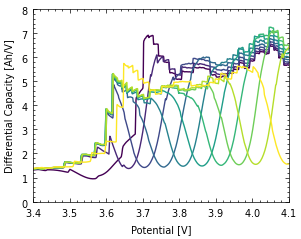

In [62]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
color = colormap(norm(np.linspace(0,1,10)))
for i in range(10):
    ax.plot(ergs[i]["V"],-ergs[i]["dQdV"]/3600,c=color[i])
plt.ylim(0,8)
plt.xlim(3.4,4.1)

plt.ylabel('Differential Capacity [Ah/V]')
plt.xlabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dqdv_final_2_zoom.svg")

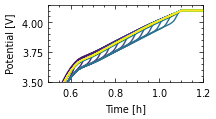

In [162]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True,figsize=(2,1))
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
color = colormap(norm(np.linspace(0,1,40)))
for i in range(40):
    ax.plot(ergs[i]["t"][10:,]/3600,ergs[i]["V"][10:,],c=color[i])
plt.xlim(0.5,1.2)
plt.ylim(3.5,4.15)
plt.xlabel('Time [h]')
plt.ylabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dqdv_final_pot_2.svg")


In [140]:
ergs = []
for V0 in [0.1]:
    for t0 in tqdm(np.linspace(0,3600*1.5,40)):
        for brt in [36]:
            ti = np.linspace(set_voltage_old[0,0],set_voltage_old[0,-1],1000)
            Vi = interp1d(set_voltage_old[0,:],set_voltage_old[1,:])(ti)
            
            Vm,VM = min(Vi),max(Vi)
            atan = V0*np.arctan((ti-t0)/brt)/np.pi
            #schwere geburt ...
            Vi += atan
            Vi = (Vi-min(Vi))
            Vi /= max(Vi)
            Vi *= (VM-Vm)
            Vi += Vm
            
            #plt.plot(ti,Vi)
            #plt.plot(set_voltage_old[0,:],set_voltage_old[1,:])
            
            set_voltage = np.array([ti,Vi])
            
            experiment_sv = pybamm.Experiment(
                [
                    (
                        "Rest for 30 minutes",
                        pybamm.step.voltage(set_voltage.T),
                        "Hold at 4.1V until C/50",
                        #"Rest for 30 minutes",
                        #"Discharge at 1C until 2.6799V",
                    ),
                ]
            )   
            model_sv = pybamm.lithium_ion.DFN(    {
        "SEI": "ec reaction limited",
        "SEI film resistance": "distributed",
        "SEI porosity change": "true",
        "lithium plating": "irreversible",
        "lithium plating porosity change": "true",
    })
            sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
            solution_sv = sim_sv.solve(initial_soc=0.0)

        t_sv = solution_sv["Time [s]"].data
        V_sv = solution_sv["Voltage [V]"].data
        A_sv = solution_sv["Current [A]"].data
        tloss = solution_sv["Total lithium lost [mol]"].data
        seiloss = solution_sv["Loss of lithium to SEI [mol]"].data
        Qc = cumtrapz(A_sv, t_sv, initial=0)
        dQdV = np.gradient(Qc,V_sv,edge_order=2)
        ergs.append(dict(t=t_sv,V=V_sv,A=A_sv,Vintend=V,dQdV=dQdV,n=n,amp=amp,tloss=tloss,seiloss=seiloss))

100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


In [141]:
V0 = 0 
t0 = 0
ti = np.linspace(set_voltage_old[0,0],set_voltage_old[0,-1],1000)
Vi = interp1d(set_voltage_old[0,:],set_voltage_old[1,:])(ti)

Vm,VM = min(Vi),max(Vi)
atan = V0*np.arctan((ti-t0)/brt)/np.pi
#schwere geburt ...
Vi += atan
Vi = (Vi-min(Vi))
Vi /= max(Vi)
Vi *= (VM-Vm)
Vi += Vm

#plt.plot(ti,Vi)
#plt.plot(set_voltage_old[0,:],set_voltage_old[1,:])

set_voltage = np.array([ti,Vi])

experiment_sv = pybamm.Experiment(
    [
        (
            "Rest for 30 minutes",
            pybamm.step.voltage(set_voltage.T),
            "Hold at 4.1V until C/50",
            #"Rest for 30 minutes",
            #"Discharge at 1C until 2.6799V",
        ),
    ]
)   
model_sv = pybamm.lithium_ion.DFN(    {
"SEI": "ec reaction limited",
"SEI film resistance": "distributed",
"SEI porosity change": "true",
"lithium plating": "irreversible",
"lithium plating porosity change": "true",
})
sim_sv = pybamm.Simulation(model_sv, experiment=experiment_sv, solver=pybamm.CasadiSolver(mode='safe'),parameter_values = pybamm.ParameterValues("OKane2022"))
solution_sv = sim_sv.solve(initial_soc=0.0)

t_sv = solution_sv["Time [s]"].data
V_sv = solution_sv["Voltage [V]"].data
A_sv = solution_sv["Current [A]"].data
tloss = solution_sv["Total lithium lost [mol]"].data
seiloss = solution_sv["Loss of lithium to SEI [mol]"].data
Qc = cumtrapz(A_sv, t_sv, initial=0)
dQdV = np.gradient(Qc,V_sv,edge_order=2)
ergs.append(dict(t=t_sv,V=V_sv,A=A_sv,Vintend=V,dQdV=dQdV,n=n,amp=amp,tloss=tloss,seiloss=seiloss))

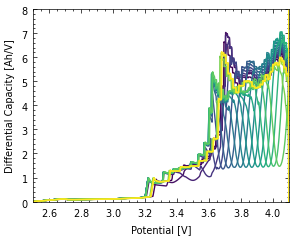

In [146]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
color = colormap(norm(np.linspace(0,1,21)))
for i in range(21):
    ax.plot(ergs[i]["V"],-ergs[i]["dQdV"]/3600,c=color[i])

plt.ylim(0,8)
plt.xlim(2.5,4.1)

plt.ylabel('Differential Capacity [Ah/V]')
plt.xlabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/voltage_005_3600.svg")#was 0.1 and 2000

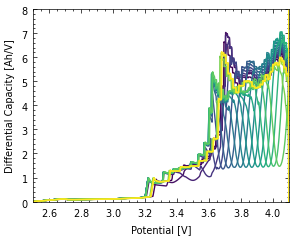

In [147]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
color = colormap(norm(np.linspace(0,1,21)))
for i in range(21):
    ax.plot(ergs[i]["V"],-ergs[i]["dQdV"]/3600,c=color[i])

plt.ylim(0,8)
plt.xlim(2.5,4.1)

plt.ylabel('Differential Capacity [Ah/V]')
plt.xlabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dqdv_final_new.svg")

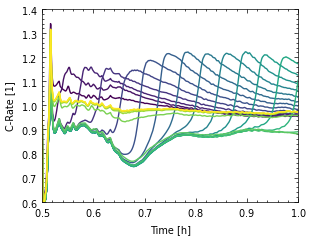

In [148]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
color = colormap(norm(np.linspace(0,1,21)))
for i in range(21):
    ax.plot(ergs[i]["t"]/3600,-ergs[i]["A"]/5.0,c=color[i])

plt.ylim(0.6,1.4)
plt.xlim(0.5,1.)

plt.ylabel('C-Rate [1]')
plt.xlabel('Time [h]')
plt.savefig("/Users/helgesorenstein/Documents/python/current.svg")

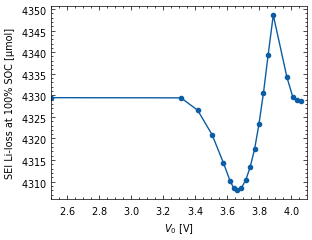

In [149]:
Vr,seil = [],[]
for i in range(20):
    tcenterix = np.argmin(abs(ergs[i]["t"]-30*60-np.linspace(0,2000,20)[i]))
    Vr.append(ergs[i]["V"][tcenterix])
    seil.append(ergs[i]["seiloss"][-1])
plt.plot(Vr,np.array(seil)*10**6,'-o')
plt.xlabel("$V_0$ [V]")
plt.xlim(2.5,4.1)
plt.ylabel("SEI Li-loss at 100% SOC [µmol]")
plt.savefig("/Users/helgesorenstein/Documents/python/leloss_2.svg")

In [150]:
mi =np.argmin(seil)
maxi =np.argmax(seil)

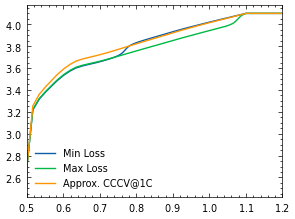

In [151]:
plt.plot(ergs[mi]["t"]/3600,ergs[mi]["V"],label="Min Loss")
plt.plot(ergs[maxi]["t"]/3600,ergs[maxi]["V"],label="Max Loss")
plt.plot(ergs[-1]["t"]/3600,ergs[-1]["V"],label="Approx. CCCV@1C")
plt.xlim(0.5,1.2)
plt.legend()
plt.savefig("/Users/helgesorenstein/Documents/python/voltage_profile.svg")

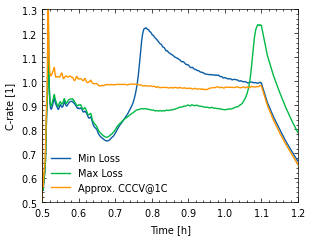

In [152]:
import matplotlib.pyplot as plt

plt.plot(ergs[mi]["t"]/3600, -ergs[mi]["A"]/5.0, label="Min Loss")
plt.plot(ergs[maxi]["t"]/3600, -ergs[maxi]["A"]/5.0, label="Max Loss")
plt.plot(ergs[-1]["t"]/3600, -ergs[-1]["A"]/5.0, label="Approx. CCCV@1C")
plt.xlim(0.5, 1.2)
plt.ylim(0.5, 1.3)
plt.xlabel("Time [h]")
plt.ylabel("C-rate [1]")
plt.legend()
plt.savefig("/Users/helgesorenstein/Documents/python/current_profile.svg")

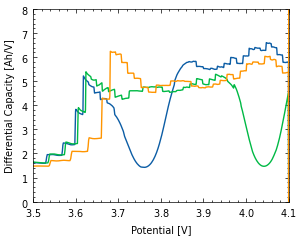

In [159]:
colormap = plt.get_cmap('viridis')

fig,ax = plt.subplots(1,1,sharex=True, sharey=True)
#first those with amplitude differences and no shift
norm = mcolors.Normalize(vmin=0, vmax=1)
for i in [mi,maxi,-1]:
    ax.plot(ergs[i]["V"],-ergs[i]["dQdV"]/3600)

plt.ylim(0,8)
plt.xlim(3.5,4.1)

plt.ylabel('Differential Capacity [Ah/V]')
plt.xlabel('Potential [V]')
plt.savefig("/Users/helgesorenstein/Documents/python/dqdv_final_new_select.svg")